# Part 3: Advanced Link-level Simulations

This tutorial will guide you through Sionna, from its basic principles to the implementation of a point-to-point link with a 5G NR compliant code and a 3GPP channel model.
You will also learn how to write custom trainable layers by implementing a state of the art neural receiver, and how to train and evaluate end-to-end communication systems.

The tutorial is structured in four notebooks:

- Part I: Getting started with Sionna

- Part II: Differentiable Communication Systems

- **Part III: Advanced Link-level Simulations**

- Part IV: Toward Learned Receivers


The [official documentation](https://nvlabs.github.io/sionna ) provides key material on how to use Sionna and how its components are implemented.

* [Imports](#Imports)
* [OFDM Resource Grid and Stream Management](#OFDM-Resource-Grid-and-Stream-Management)
* [Antenna Arrays](#Antenna-Arrays)
* [Channel Model](#Channel-Model)
* [Uplink Transmission in the Frequency Domain](#Uplink-Transmission-in-the-Frequency-Domain)

## Imports

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Import TensorFlow and NumPy
import tensorflow as tf
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')
import numpy as np

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt

# For the implementation of the Keras models
from tensorflow.keras import Model

## OFDM Resource Grid and Stream Management

We will setup a realistic SIMO point-to-point link between a mobile user terminal (UT) and a base station (BS). The system we will setup is shown in the figure below.

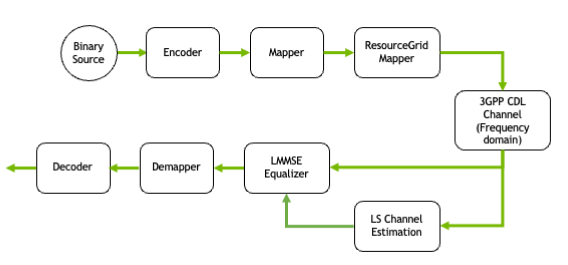

### Stream Management

For any type of MIMO simulations, it is required to setup a `StreamManagement` object.
It determines which transmitters and receivers communicate data streams with each other.
In our scenario, we will configure a single UT equipped with a single antenna and a single BS equipped with multiple antennas.
Whether the UT or BS is considered as a transmitter depends on the link direction, which can be
either uplink or downlink. The `StreamManagement` has many properties that are used by other components,
such as precoding and equalization.

We will configure the system here such that the number of streams per transmitter
is equal to the number of UT antennas.

In [2]:
# Define the number of UT and BS antennas
NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 4

# The number of transmitted streams is equal to the number of UT antennas
# in both uplink and downlink
NUM_STREAMS_PER_TX = NUM_UT_ANT

# Create an RX-TX association matrix.
# RX_TX_ASSOCIATION[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change.
# For example, considering a system with 2 RX and 4 TX, the RX-TX
# association matrix could be
# [ [1 , 1, 0, 0],
#   [0 , 0, 1, 1] ]
# which indicates that the RX 0 receives from TX 0 and 1, and RX 1 receives from
# TX 2 and 3.
#
# In this notebook, as we have only a single transmitter and receiver,
# the RX-TX association matrix is simply:
RX_TX_ASSOCIATION = np.array([[1]])

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly easy. However, it can get more involved
# for simulations with many transmitters and receivers.
STREAM_MANAGEMENT = sn.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

### OFDM Resource Grid

Next, we configure an OFDM `ResourceGrid` spanning multiple OFDM symbols.
The resource grid contains data symbols and pilots and is equivalent to a
*slot* in 4G/5G terminology. Although it is not relevant for our simulation, we null the DC subcarrier
and a few guard carriers to the left and right of the spectrum. Also a cyclic prefix is added.

During the creation of the `ResourceGrid`, a `PilotPattern` is automatically generated.
We could have alternatively created a `PilotPattern` first and then provided it as initialization parameter.
When multiple streams are considered, the corresponding pilot patterns must be orthogonal.
By default, orthogonal pilots are setup when considering such systems.

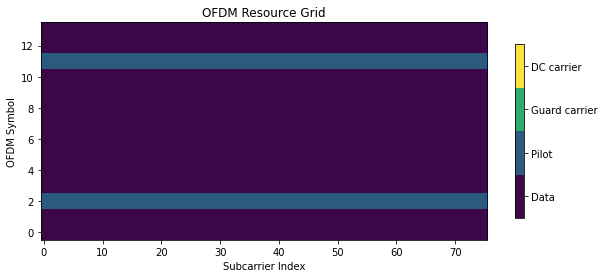

In [3]:
RESOURCE_GRID = sn.ofdm.ResourceGrid( num_ofdm_symbols=14,
                                      fft_size=76,
                                      subcarrier_spacing=30e3,
                                      num_tx=NUM_UT,
                                      num_streams_per_tx=NUM_STREAMS_PER_TX,
                                      cyclic_prefix_length=6,
                                      pilot_pattern="kronecker",
                                      pilot_ofdm_symbol_indices=[2,11])
RESOURCE_GRID.show();

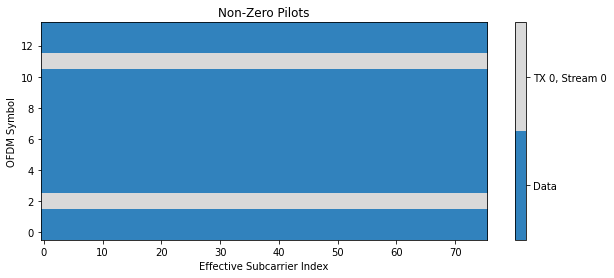

In [4]:
RESOURCE_GRID.pilot_pattern.show();

**Task:** You can try different pilot patterns, FFT size, number of OFDM symbols, and visualize how it affects the resource grid.

See the notebook [MIMO_OFDM_Transmissions_over_CDL](https://nvlabs.github.io/sionna/examples/MIMO_OFDM_Transmissions_over_CDL.html) for more advanced examples.

## Antenna Arrays

We need to configure the antenna arrays used by the UT and BS.
This can be ignored for simple channel models, such as `AWGN`, `RayleighBlockFading`, or `TDL` which do not account for antenna array geometries and antenna radiation patterns. However, other models, such as `CDL`, `UMi`, `UMa`, and `RMa` from the 3GPP 38.901 specification, require it.

We will assume here that UT is equipped with one vertically single-polarized antenna and the BS antenna array is composed of dual cross-polarized antenna elements with an antenna pattern defined in the [3GPP 38.901 specification](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3173). By default, the antenna elements are spaced half of a wavelength apart in both vertical and horizontal directions. You can define your own antenna geometries an radiation patterns if needed.

An `AntennaArray` is always defined in the y-z plane. Its final orientation will be determined by the orientation of the UT or BS. This parameter can be configured in the `ChannelModel` that we will create later.

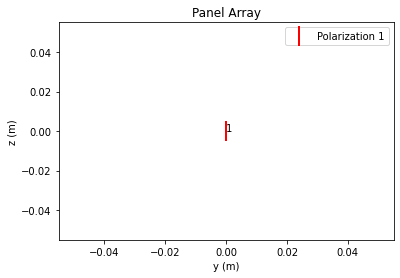

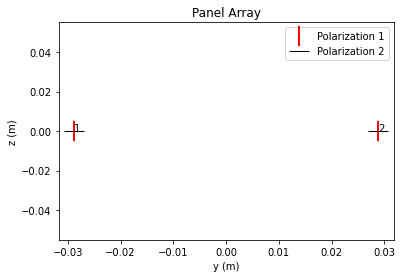

In [5]:
CARRIER_FREQUENCY = 2.6e9 # Carrier frequency in Hz.
                          # This is needed here to define the antenna element spacing.

UT_ARRAY = sn.channel.tr38901.Antenna(  polarization="single",
                                        polarization_type="V", 
                                        antenna_pattern="38.901",
                                        carrier_frequency=CARRIER_FREQUENCY)
UT_ARRAY.show();

BS_ARRAY = sn.channel.tr38901.AntennaArray( num_rows=1,
                                            num_cols=int(NUM_BS_ANT/2),
                                            polarization="dual",
                                            polarization_type="cross",
                                            antenna_pattern="38.901", # Try 'omni'
                                            carrier_frequency=CARRIER_FREQUENCY)
BS_ARRAY.show();

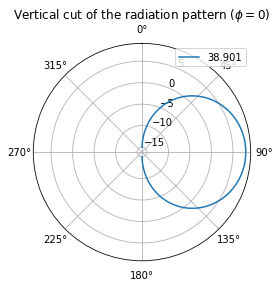

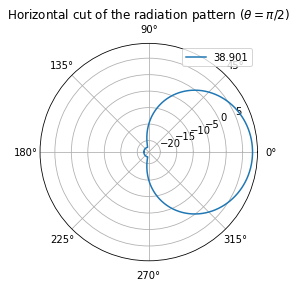

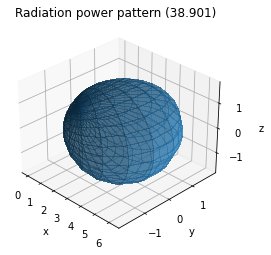

In [6]:
BS_ARRAY.show_element_radiation_pattern();

**Task:** You can try different antenna pattern ("omni"), polarization, and array geometries.

## Channel Model

Sionna implements the CDL, TDL, UMi, UMa, and RMa models from [3GPP TR 38.901](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3173), as well as Rayleigh block fading.

Note that:
* TDL only supports SISO
* CDL only supports single-user, possibly with multiple antenna
* UMi, UMa, and RMa support single- and multi-user

*Remark:* The TDL and CDL models correspond to fixed power delay profiles and fixed angles.

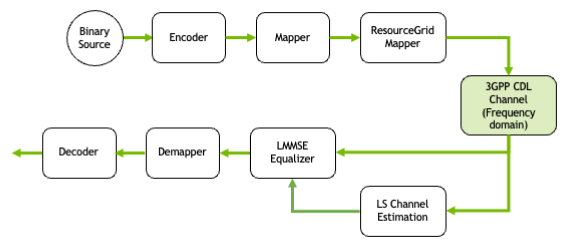

We consider the 3GPP CDL model family in this notebook.

In [7]:
DELAY_SPREAD = 100e-9 # Nominal delay spread in [s]. Please see the CDL documentation
                      # about how to choose this value.

DIRECTION = "uplink"  # The `direction` determines if the UT or BS is transmitting.
                      # In the `uplink`, the UT is transmitting.

CDL_MODEL = "C"       # Suitable values are ["A", "B", "C", "D", "E"]

SPEED = 10.0          # UT speed [m/s]. BSs are always assumed to be fixed.
                     # The direction of travel will chosen randomly within the x-y plane.

# Configure a channel impulse reponse (CIR) generator for the CDL model.
CDL = sn.channel.tr38901.CDL(CDL_MODEL,
                             DELAY_SPREAD,
                             CARRIER_FREQUENCY,
                             UT_ARRAY,
                             BS_ARRAY,
                             DIRECTION,
                             min_speed=SPEED)

The instance `CDL` of the CDL model can be used to generate batches of random realizations of continuous-time
channel impulse responses, consisting of complex gains `a` and delays `tau` for each path. 
To account for time-varying channels, a channel impulse responses is sampled at the `sampling_frequency` for `num_time_samples` samples.
For more details on this, please have a look at the API documentation of the channel models.

In order to model the channel in the frequency domain, we need `num_ofdm_symbols` samples that are taken once per `ofdm_symbol_duration`, which corresponds to the length of an OFDM symbol plus the cyclic prefix.

In [8]:
BATCH_SIZE = 128 # How many examples are processed by Sionna in parallel

a, tau = CDL(batch_size=BATCH_SIZE,
             num_time_steps=RESOURCE_GRID.num_ofdm_symbols,
             sampling_frequency=1/RESOURCE_GRID.ofdm_symbol_duration)

The path gains `a` have shape\
`[batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]`\
and the delays `tau` have shape\
`[batch_size, num_rx, num_tx, num_paths]`.

In [9]:
print("Shape of the path gains: ", a.shape)
print("Shape of the delays:", tau.shape)

Shape of the path gains:  (128, 1, 4, 1, 1, 24, 14)
Shape of the delays: (128, 1, 1, 24)


The delays are assumed to be static within the time-window of interest. Only the complex path gains change over time.
The following two figures depict the channel impulse response at a particular time instant and the time-evolution of the gain of one path, respectively.

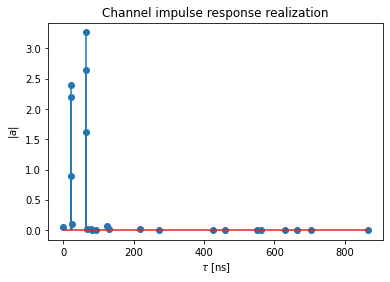

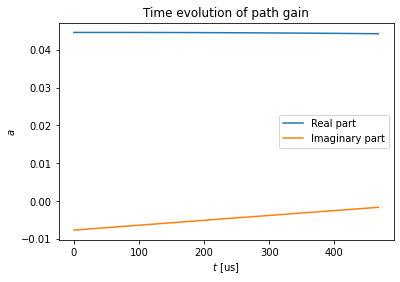

In [10]:
plt.figure()
plt.title("Channel impulse response realization")
plt.stem(tau[0,0,0,:]/1e-9, np.abs(a)[0,0,0,0,0,:,0])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")


plt.figure()
plt.title("Time evolution of path gain")
plt.plot(np.arange(RESOURCE_GRID.num_ofdm_symbols)*RESOURCE_GRID.ofdm_symbol_duration/1e-6, np.real(a)[0,0,0,0,0,0,:])
plt.plot(np.arange(RESOURCE_GRID.num_ofdm_symbols)*RESOURCE_GRID.ofdm_symbol_duration/1e-6, np.imag(a)[0,0,0,0,0,0,:])
plt.legend(["Real part", "Imaginary part"])

plt.xlabel(r"$t$ [us]")
plt.ylabel(r"$a$");

See the notebook [Realistic_Multiuser_MIMO_Simulations](https://nvlabs.github.io/sionna/examples/Realistic_Multiuser_MIMO_Simulations.html) for more advanced examples.

## Uplink Transmission in the Frequency Domain

We are now ready to simulate a transmission.

In the following, the channel is simulated in the frequency domain. Therefore, the channel is assumed to be constant over the duration of an OFDM symbol, which leads to not simulating the intercarrier interference (ICI) that could occur due to channel aging over the duration of OFDM symbols.

The `OFDMChannel` layer is used to simulate the channel in the frequency domain and takes care of sampling channel impulse responses, computing the frequency responses, and applying the channel transfer function to the channel inputs (including AWGN).

Note that it is also possible to simulate the channel in time domain using the `TimeChannel` layer, which enables simulation of ICI.
For more information, please have a look at the API documentation.

In [11]:
NUM_BITS_PER_SYMBOL = 2 # QPSK
CODERATE = 0.5

# Number of coded bits in a resource grid
n = int(RESOURCE_GRID.num_data_symbols*NUM_BITS_PER_SYMBOL)
# Number of information bits in a resource groud
k = int(n*CODERATE)

# The binary source will create batches of information bits
binary_source = sn.utils.BinarySource()

# The encoder maps information bits to coded bits
encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)

# Frequency domain channel
channel = sn.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=True)

# The LS channel estimator will provide channel estimates and error variances
ls_est = sn.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = sn.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)

# The demapper produces LLR for all coded bits
demapper = sn.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL)

# The decoder provides hard-decisions on the information bits
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder, hard_out=True)

Let's now simulate the transmission, and look at the shape of the layers outputs at each stage.

The utility function `ebnodb2no` takes as additional input the resource grid to account for the pilots when computing the noise power spectral density ratio $N_0$ from the energy per bit to noise power spectral density ratio $E_b/N_0$ (in dB).

In [12]:
no = sn.utils.ebnodb2no(ebno_db=10.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=CODERATE,
                        resource_grid=RESOURCE_GRID)

# Transmitter
bits = binary_source([BATCH_SIZE, NUM_UT, RESOURCE_GRID.num_streams_per_tx, k])
print("Shape of bits: ", bits.shape)
codewords = encoder(bits)
print("Shape of codewords: ", codewords.shape)
x = mapper(codewords)
print("Shape of x: ", x.shape)
x_rg = rg_mapper(x)
print("Shape of x_rg: ", x_rg.shape)

# Channel
y, h_freq = channel([x_rg, no])
print("Shape of y_rg: ", y.shape)
print("Shape of h_freq: ", h_freq.shape)

# Receiver
h_hat, err_var = ls_est ([y, no])
print("Shape of h_hat: ", h_hat.shape)
print("Shape of err_var: ", err_var.shape)
x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
print("Shape of x_hat: ", x_hat.shape)
print("Shape of no_eff: ", no_eff.shape)
llr = demapper([x_hat, no_eff])
print("Shape of llr: ", llr.shape)
bits_hat = decoder(llr)
print("Shape of bits_hat: ", bits_hat.shape)

Shape of bits:  (128, 1, 1, 912)
Shape of codewords:  (128, 1, 1, 1824)
Shape of x:  (128, 1, 1, 912)
Shape of x_rg:  (128, 1, 1, 14, 76)
Shape of y_rg:  (128, 1, 4, 14, 76)
Shape of h_freq:  (128, 1, 4, 1, 1, 14, 76)
Shape of h_hat:  (128, 1, 4, 1, 1, 14, 76)
Shape of err_var:  (1, 1, 1, 1, 1, 14, 76)
Shape of x_hat:  (128, 1, 1, 912)
Shape of no_eff:  (128, 1, 1, 912)
Shape of llr:  (128, 1, 1, 1824)
Shape of bits_hat:  (128, 1, 1, 912)


The next cell implements the previous system as a Keras model.

Moreover, a boolean given as parameter to the initializer enables using either LS estimation or perfect CSI, as shown in the figure below.

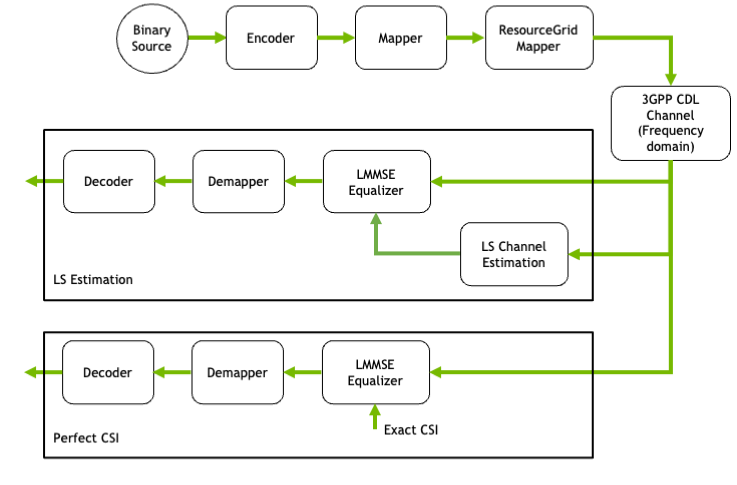

In [13]:
class OFDMSystem(Model): # Inherits from Keras Model

    def __init__(self, perfect_csi):
        super().__init__() # Must call the Keras model initializer

        self.perfect_csi = perfect_csi

        n = int(RESOURCE_GRID.num_data_symbols*NUM_BITS_PER_SYMBOL) # Number of coded bits
        k = int(n*CODERATE) # Number of information bits
        self.k = k

        # The binary source will create batches of information bits
        self.binary_source = sn.utils.BinarySource()

        # The encoder maps information bits to coded bits
        self.encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

        # The resource grid mapper maps symbols onto an OFDM resource grid
        self.rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)

        # Frequency domain channel
        self.channel = sn.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=True)

        # The LS channel estimator will provide channel estimates and error variances
        self.ls_est = sn.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

        # The LMMSE equalizer will provide soft symbols together with noise variance estimates
        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)

        # The demapper produces LLR for all coded bits
        self.demapper = sn.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL)

        # The decoder provides hard-decisions on the information bits
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)

        # Transmitter
        bits = self.binary_source([batch_size, NUM_UT, RESOURCE_GRID.num_streams_per_tx, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)

        # Channel
        y, h_freq = self.channel([x_rg, no])

        # Receiver
        if self.perfect_csi:
            h_hat, err_var = h_freq, 0.
        else:
            h_hat, err_var = self.ls_est ([y, no])
        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])
        llr = self.demapper([x_hat, no_eff])
        bits_hat = self.decoder(llr)

        return bits, bits_hat

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -8.0 | 4.2978e-01 | 1.0000e+00 |       50171 |      116736 |          128 |         128 |         7.0 |reached target block errors
   -7.421 | 4.1871e-01 | 1.0000e+00 |       48878 |      116736 |          128 |         128 |         0.2 |reached target block errors
   -6.842 | 4.1140e-01 | 1.0000e+00 |       48025 |      116736 |          128 |         128 |         0.2 |reached target block errors
   -6.263 | 4.0080e-01 | 1.0000e+00 |       46788 |      116736 |          128 |         128 |         0.2 |reached target block errors
   -5.684 | 3.8840e-01 | 1.0000e+00 |       45340 |      116736

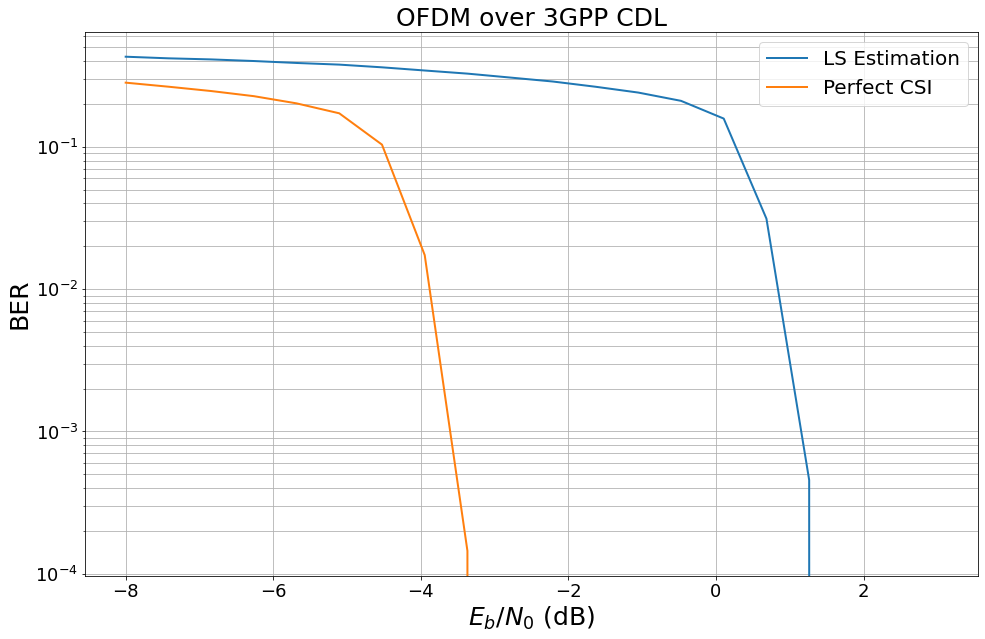

In [14]:
EBN0_DB_MIN = -8.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 3.0 # Maximum value of Eb/N0 [dB] for simulations

ber_plots = sn.utils.PlotBER("OFDM over 3GPP CDL")

model_ls = OFDMSystem(False)
ber_plots.simulate(model_ls,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="LS Estimation",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

model_pcsi = OFDMSystem(True)
ber_plots.simulate(model_pcsi,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Perfect CSI",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

ber_plots();